In [1]:
import numpy as np
import csv
import math

import pandas as pd
import geopandas as gpd

from descartes import PolygonPatch
import matplotlib.pyplot as plt
import matplotlib.patches as pltp
import seaborn as sns

Importing sample
----------------

In [2]:
with open("data/warszawa.csv") as f:
    reader = csv.reader(f, delimiter=';', quotechar='|')
    lst = []
    col_names = []
    for i,row in enumerate(reader):
        if i == 0:
            col_names = row
            continue
        lst.append(dict(zip(col_names,row)))
sample = pd.DataFrame(lst).set_index('Id')

Converting sample columns to correct data type 

In [3]:
numeric_variables = ['price_per_sqm','age','age_mean','age_median', 'age_mode', 'age_random','latitude','longitude','surface','page_views', 'price','price_per_sqm','rent', 'publicated', 'updated']

boolean_variables = ['equipment_dishwasher', 'equipment_fridge', 'equipment_oven','equipment_stove', 'equipment_tv', 'equipment_washing_machine',
                     'extras_air_conditioning', 'extras_balcony', 'extras_basement','extras_furniture', 'extras_garage', 'extras_garden', 'extras_lift',
                     'extras_separate_kitchen', 'extras_swimming_pool', 'extras_terrace','extras_two_storey', 'extras_usable_room','media_cable-television',
                     'media_internet', 'media_phone','security_alarm', 'security_anti_burglary_door','security_closed_area', 'security_entryphone', 'security_monitoring',
                     'security_roller_shutters', 'security_security']

date_variables    = ['available']

sample[numeric_variables] = sample[numeric_variables].apply(lambda x: pd.to_numeric(x,errors='coerce'))
sample[boolean_variables] = sample[boolean_variables].apply(lambda x: pd.to_numeric(x,errors='coerce'))
sample[date_variables]    = sample[date_variables].apply(lambda x: pd.to_datetime(x,errors='coerce'))

Importing geospatial data
---------------------

We import geo data that can be used to plot Warsaw map. 

In [4]:
districts = gpd.read_file('utils/waw_suburbs.geojson')
districts['title'] = districts['title'].apply(lambda x: x.lower())
districts = districts.set_index('title')
poly = districts['geometry']

District analysis
---------------------

In [5]:
sample['rent_per_sql'] = sample['rent'] / sample['surface']
sample_primary   = sample[sample['market']=='primary']          
sample_secondary = sample[sample['market']=='secondary']

maps = []
maps.append({'Sample':sample,'Variable': 'price_per_sqm','Statistics': 'mean','Title': 'Average price per sqm','Cmap': 'bwr','Formatter': lambda x: str(round(x/1000.0,1))+' k'})
maps.append({'Sample':sample_primary,'Variable': 'price_per_sqm','Statistics': 'mean','Title': 'Average price per sqm for primary market','Cmap': 'bwr','Formatter': lambda x: str(round(x/1000.0,1))+' k'})
maps.append({'Sample':sample_secondary,'Variable': 'price_per_sqm','Statistics': 'mean','Title': 'Average price per sqm for secondary market','Cmap': 'bwr','Formatter': lambda x: str(round(x/1000.0,1))+' k'})
maps.append({'Sample':sample,'Variable': 'surface','Statistics': 'mean','Title': 'Average surface of a flat','Cmap': 'bwr','Formatter': lambda x: str(round(x,1)) + 'm2'})
maps.append({'Sample':sample,'Variable': 'age_random','Statistics': 'mean','Title': 'Mean age of flat','Cmap': 'bwr','Formatter': lambda x: str(round(x,1))+' Y'})
maps.append({'Sample':sample,'Variable': 'page_views','Statistics': 'mean','Title': 'Average number of page views','Cmap': 'bwr','Formatter': lambda x: str(round(x,0))})
maps.append({'Sample':sample,'Variable': 'rent_per_sql', 'Statistics':'mean','Title':'Average rent per sq meter','Cmap': 'bwr','Formatter':lambda x: str(round(x,2))})
maps.append({'Sample':sample,'Variable': 'link', 'Statistics':'count','Title':'Number of offers','Cmap': 'bwr','Formatter':lambda x: str(round(x,0))})
maps.append({'Sample':sample,'Variable': 'extras_lift','Statistics':'mean','Title':'Percenage of flats with lift','Cmap': 'bwr','Formatter':lambda x: str(round(100.0*x,1))+'%'})
maps.append({'Sample':sample,'Variable': 'extras_garage','Statistics':'mean','Title':'Percenage of flats with garage','Cmap': 'bwr','Formatter':lambda x: str(round(100.0*x,1))+'%'})

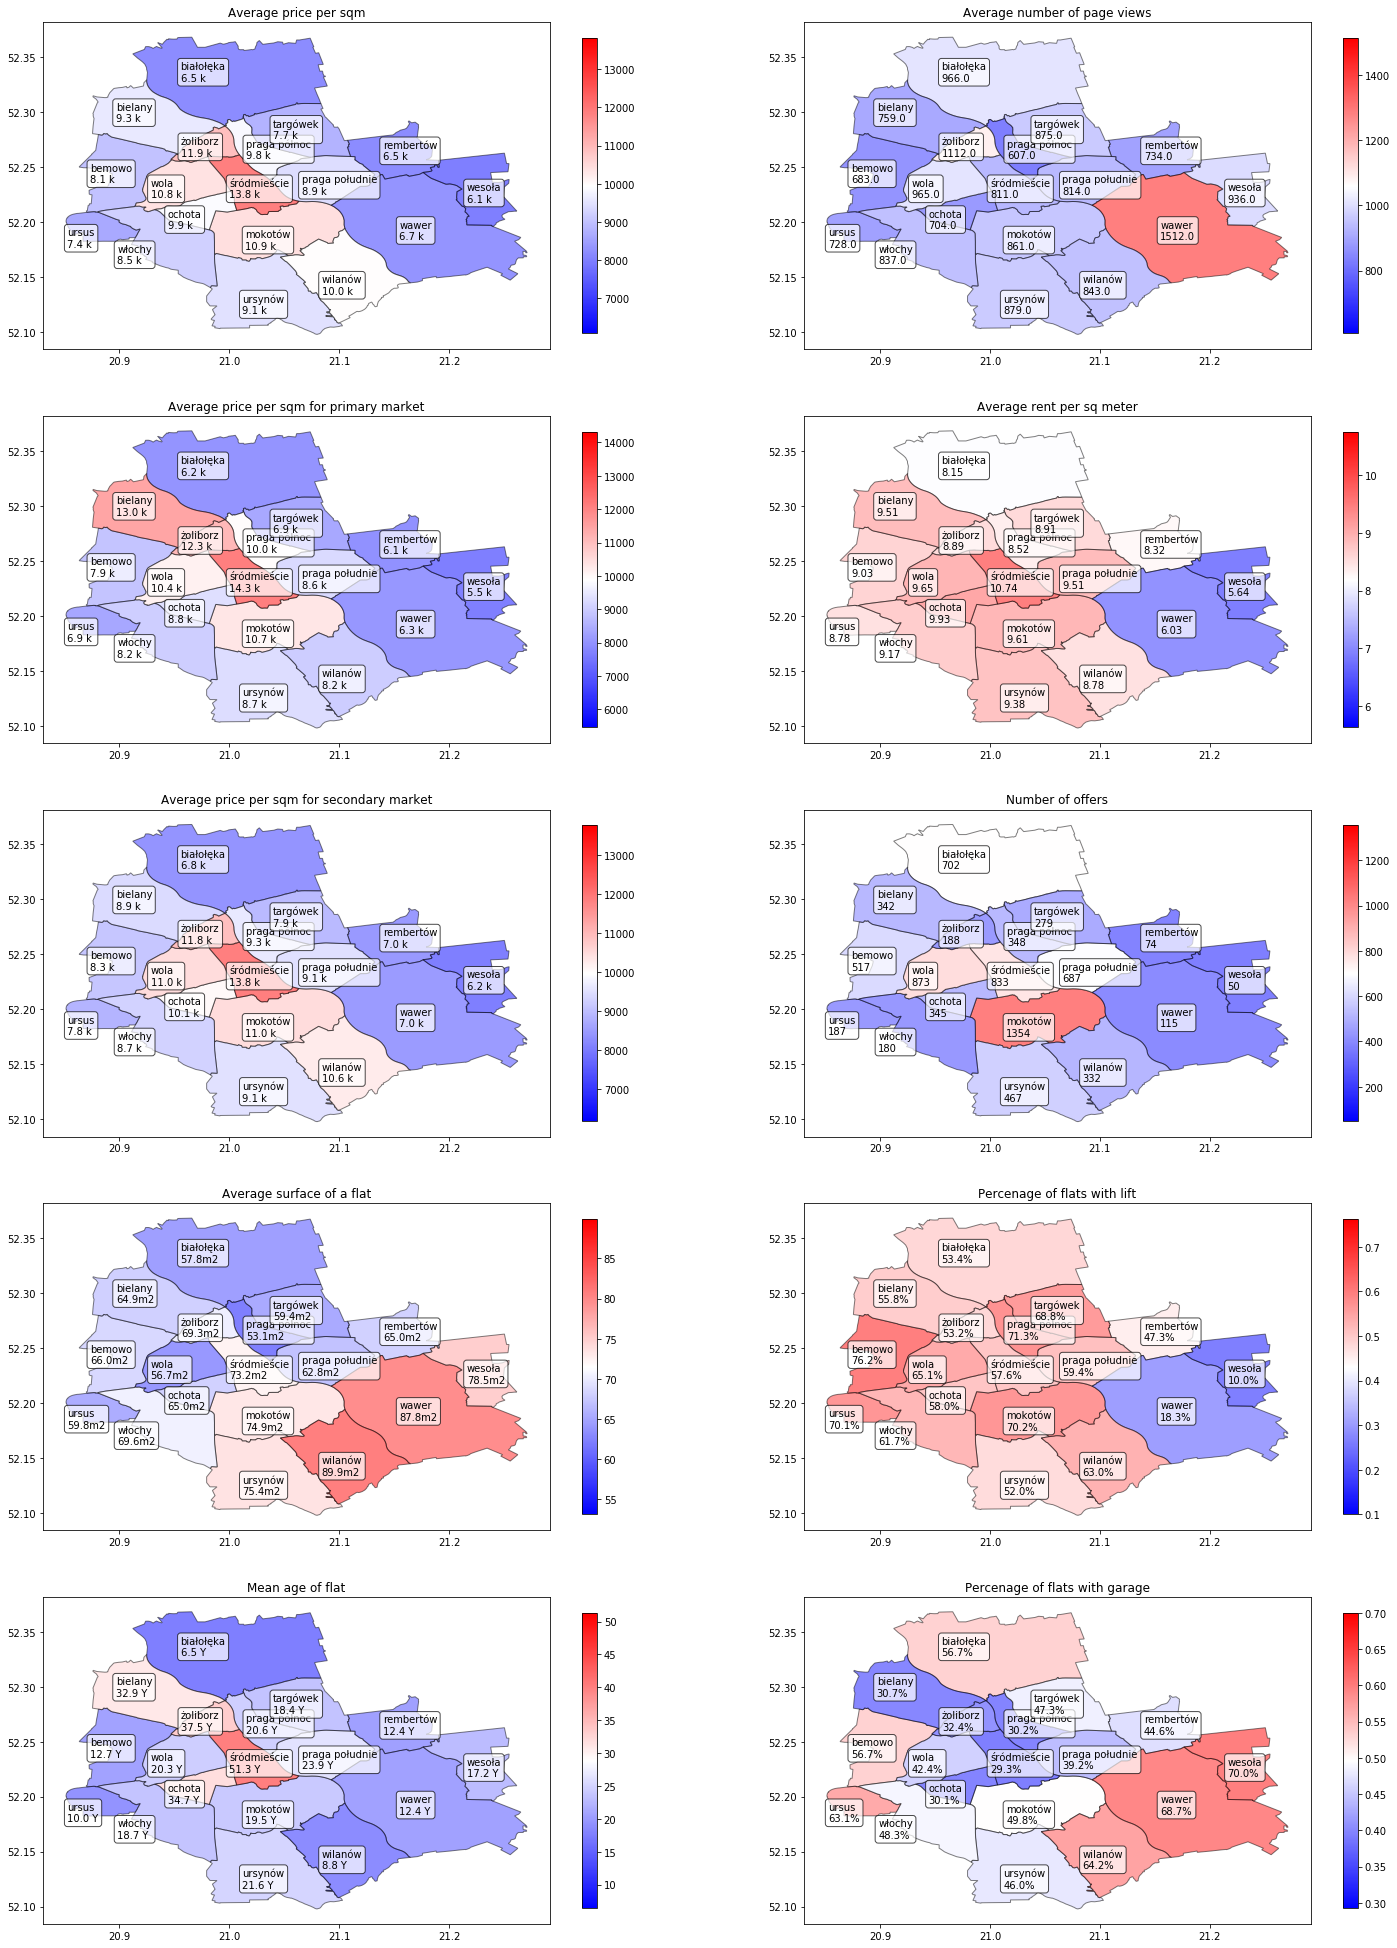

In [6]:
def scaler(sample):
    min_ = sample.min()[0]
    max_ = sample.max()[0]
    def f(x):
        return (x-min_) / (max_-min_)
    return f

number_of_rows = math.ceil(len(maps)/2)
number_of_cols = 2

fig, axes = plt.subplots(number_of_rows,number_of_cols,figsize=(25,7*number_of_rows)) 
for r in range(0,number_of_rows):
    for c in range(0,number_of_cols):

        item = maps[number_of_rows*c+r]
        cmap=plt.get_cmap(item.get('Cmap','Blues'))
        ax = axes[r][c]

        stat = item['Sample'].groupby(['Borough']).agg([item['Statistics']])[item['Variable']]
        
        f = scaler(stat)
        
        pos = []
        values = []
        for name, polygon in poly.iteritems():  
            value = stat[item['Statistics']][name]
            im = ax.add_patch(PolygonPatch(polygon, fc=cmap(f(value)), ec='k', alpha=0.5, zorder=2))
            values.append(value)        
        ax.axis('scaled')
        
        
        sm = plt.cm.ScalarMappable(cmap=item.get('Cmap','Blues'), norm=plt.Normalize(vmin=min(values), vmax=max(values)))
        sm._A = []
        cbar = fig.colorbar(sm,shrink=0.9,ax=ax)

        min_x = min([polygon[1].bounds[0] for polygon in poly.iteritems()])
        max_x = max([polygon[1].bounds[2] for polygon in poly.iteritems()])
        min_y = min([polygon[1].bounds[1] for polygon in poly.iteritems()])
        max_y = max([polygon[1].bounds[3] for polygon in poly.iteritems()])   

        props = dict(boxstyle='round', facecolor='white', alpha=0.7)
        for name, polygon in poly.iteritems():  
            borough_min_x, borough_min_y, borough_max_x, borough_max_y = polygon.bounds
            x = (0.3*borough_max_x + (1.0-0.3)*borough_min_x - min_x) / (max_x-min_x)
            y = (0.6*borough_max_y + (1.0-0.6)*borough_min_y - min_y) / (max_y-min_y)
            #x = 0.5
            #y = 0.5
            ax.text(x, y, name + '\n' + item['Formatter'](stat[item['Statistics']][name]), transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=props)
        ax.set_title(item['Title'])

plt.show()

Detailed analysis
---------------------

Observations that were originally published with street names may be plotted on the map as a single point. The reason is that we can identify flat position by longitude and latitude.

In [7]:
price_q05 = sample['price_per_sqm'].quantile(0.05)
price_q95 = sample['price_per_sqm'].quantile(0.95)
filter_price = sample[(sample['price_per_sqm'] > price_q05 ) & (sample['price_per_sqm'] < price_q95)]

surface_q95 = sample['surface'].quantile(0.95)
filter_surface = sample[(sample['surface'] < surface_q95 )]

age_q90 = sample['age_random'].quantile(0.90)
filter_age = sample[(sample['age_random'] < age_q90 )]

pw_q80 = sample['page_views'].quantile(0.80)
filter_pw = sample[(sample['page_views'] < pw_q80 )]

maps = []

maps.append({'Sample':sample,'Variable': 'market','Discrete':True,'Title': 'Market','Cmap': 'Set3'})
maps.append({'Sample':sample,'Variable': 'building_material','Discrete':True,'Title': 'Building material','Cmap': 'Set3'})
maps.append({'Sample':sample,'Variable': 'extras_garage','Discrete':True,'Title': 'Garage','Cmap': 'Set3'})
maps.append({'Sample':sample,'Variable': 'building_type','Discrete':True,'Title': 'Building type','Cmap': 'Set3'})

maps.append({'Sample':filter_price,'Variable': 'price_per_sqm','Discrete':False,'Title': 'Price for sq meter','Cmap': 'bwr'})
maps.append({'Sample':filter_surface,'Variable': 'surface','Discrete':False,'Title': 'Surface','Cmap': 'bwr'})
maps.append({'Sample':filter_age,'Variable': 'age_random','Discrete':False,'Title': 'Age of the flat','Cmap': 'bwr'})
maps.append({'Sample':filter_pw,'Variable': 'page_views','Discrete':False,'Title': 'Number of page views','Cmap': 'bwr'})


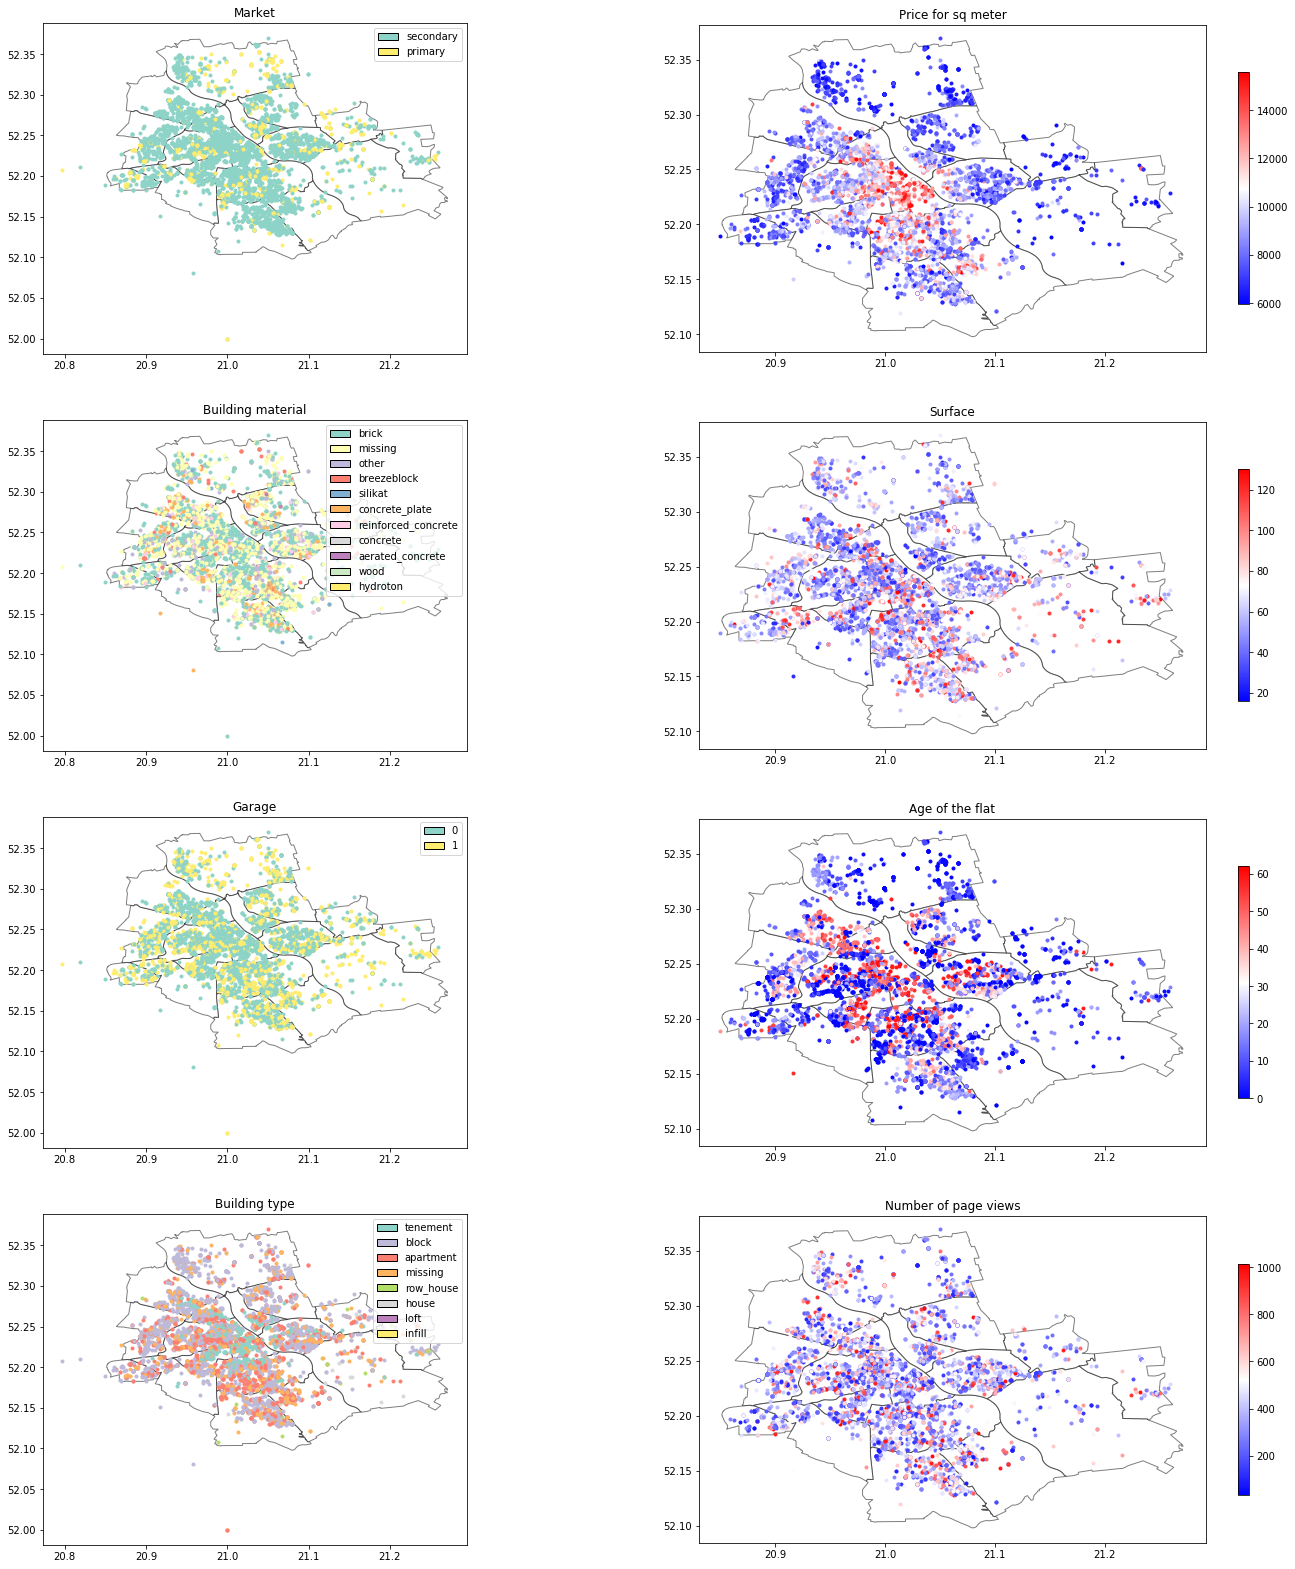

In [8]:
def scaler(sample):
    min_ = sample.min()[0]
    max_ = sample.max()[0]
    def f(x):
        return (x-min_) / (max_-min_)
    return f

number_of_rows = math.ceil(len(maps)/2)
number_of_cols = 2

fig, axes = plt.subplots(number_of_rows,number_of_cols,figsize=(25,7*number_of_rows)) 
for r in range(0,number_of_rows):
    for c in range(0,number_of_cols):
        item = maps[number_of_rows*c+r]
        cmap=plt.get_cmap(item.get('Cmap','Blues'))
        var = item['Variable']
        ax = axes[r][c]
        for name, polygon in poly.iteritems():  
            ax.add_patch(PolygonPatch(polygon, fc='w', ec='k', alpha=0.5, zorder=2))
        ax.axis('scaled')
        if item['Discrete']:
            list_of_values = list(item['Sample'][var].unique())
            colors = dict( zip(list_of_values, cmap(np.linspace(0.05,0.95,len(list_of_values)))))
            values = []
            for lon,lat,v,b in zip(item['Sample']['longitude'],item['Sample']['latitude'],item['Sample'][var],item['Sample']['orig_street']):
                if b:
                    ax.plot((lon), (lat), 'o',c=colors[v], markersize=3, )
            ax.axis('scaled')
            legend_elements = []
            for value in list_of_values:
                legend_elements.append(pltp.Patch(facecolor=colors[value], edgecolor='k',label=value))

            ax.legend(handles=legend_elements, loc='upper right')

        else:
            cmap=plt.get_cmap(item.get('Cmap','Blues'))
            min_value = min(item['Sample'][item['Variable']])
            max_value = max(item['Sample'][item['Variable']])
            for lon,lat,v,b in zip(item['Sample']['longitude'],item['Sample']['latitude'],item['Sample'][var],item['Sample']['orig_street']):
                if b:
                    ax.plot((lon), (lat), 'o',c=cmap((v-min_value) / (max_value-min_value)), markersize=3, )

            sm = plt.cm.ScalarMappable(cmap=item.get('Cmap','Blues'), norm=plt.Normalize(vmin=min_value, vmax=max_value))
            sm._A = []
            cbar = fig.colorbar(sm,shrink=0.7,ax=ax)
        ax.set_title(item['Title'])
plt.show()

Most expensive locations
-------------------

In [9]:
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

In [82]:
expensive = sample[(sample['orig_street']=="True") & (sample['longitude']<21.2)].sort_values(by=['price_per_sqm'], ascending=False)
X = expensive.values[0:250]

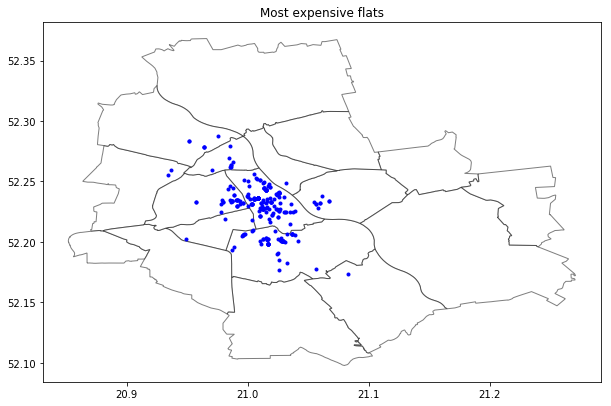

In [83]:
fig, ax = plt.subplots(figsize=(10,10)) 

for name, polygon in poly.iteritems():  
    ax.add_patch(PolygonPatch(polygon, fc='w', ec='k', alpha=0.5, zorder=2))
ax.axis('scaled')

for item in X:
    ax.plot((item[0]), (item[1]), 'o', c='blue', markersize=3, )
ax.axis('scaled')
ax.set_title('Most expensive flats')
plt.show()

In [84]:
metrics = ['euclidean','cityblock','sqeuclidean','cosine','correlation','hamming','jaccard','chebyshev','canberra','braycurtis','mahalanobis']
methods = [ 'single','complete','centroid','median','ward']

clusters_analysis = pd.DataFrame()
for metric in metrics:
    for method in methods:            
        try:
            Z = linkage(X, metric=metric,method=method)
            for clust in range(3,15):
                clusters = fcluster(Z, clust, criterion='maxclust')
                unique, counts = np.unique(clusters, return_counts=True)
                silhouette_avg = silhouette_score(X, clusters)
                res = {'Cluster_no':clust,'Method':method,'Metric':metric,'Silhouette':silhouette_avg}
                res['min'] = min(counts)/sum(counts)
                res['max'] = max(counts)/sum(counts)
                if res['max'] < 0.66 :
                    clusters_analysis = clusters_analysis.append(res,ignore_index=True)
        except:
            pass
clusters_analysis = clusters_analysis.sort_values(by=['Silhouette'], ascending=False)
print(clusters_analysis.head(10))

    Cluster_no    Method      Metric  Silhouette    max    min
33        14.0      ward   euclidean    0.502560  0.256  0.008
32        13.0      ward   euclidean    0.494451  0.256  0.008
24         5.0      ward   euclidean    0.488106  0.544  0.036
37         7.0  complete   cityblock    0.484346  0.544  0.008
89         7.0  complete  braycurtis    0.484346  0.544  0.008
90         8.0  complete  braycurtis    0.483904  0.544  0.008
38         8.0  complete   cityblock    0.483904  0.544  0.008
8         11.0  centroid   euclidean    0.482930  0.544  0.004
30        11.0      ward   euclidean    0.480706  0.256  0.008
31        12.0      ward   euclidean    0.478525  0.256  0.008


In [85]:
Z = linkage(X, metric='euclidean',method='ward')
clusters = fcluster(Z, 14, criterion='maxclust')

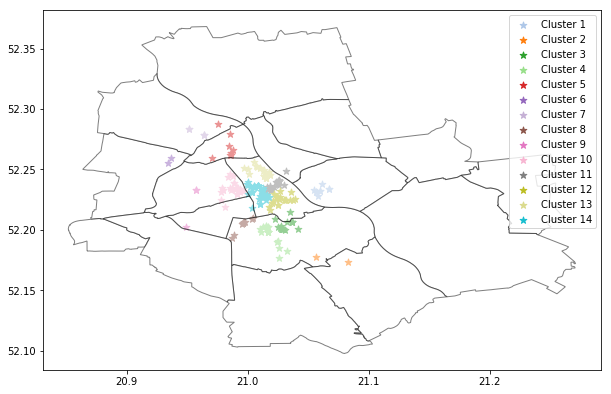

In [87]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

cm = plt.get_cmap('tab20')

for name, polygon in poly.iteritems():  
    ax.add_patch(PolygonPatch(polygon, fc='w', ec='k', alpha=0.5, zorder=2))
ax.axis('scaled')
    
for clust in range(1,clusters.max()+1):
    long = []
    lat = []
    for obs in range(0, len(Z)): 
        if clusters[obs] == float(clust):
            long.append(X[obs,0])
            lat.append(X[obs,1])
    ax.scatter(long, lat, s=50, 
                c=cm(float(clust) / (clusters.max()+1)), 
                marker='*',
                label='Cluster ' + str(clust)
                )
plt.legend()
plt.show()

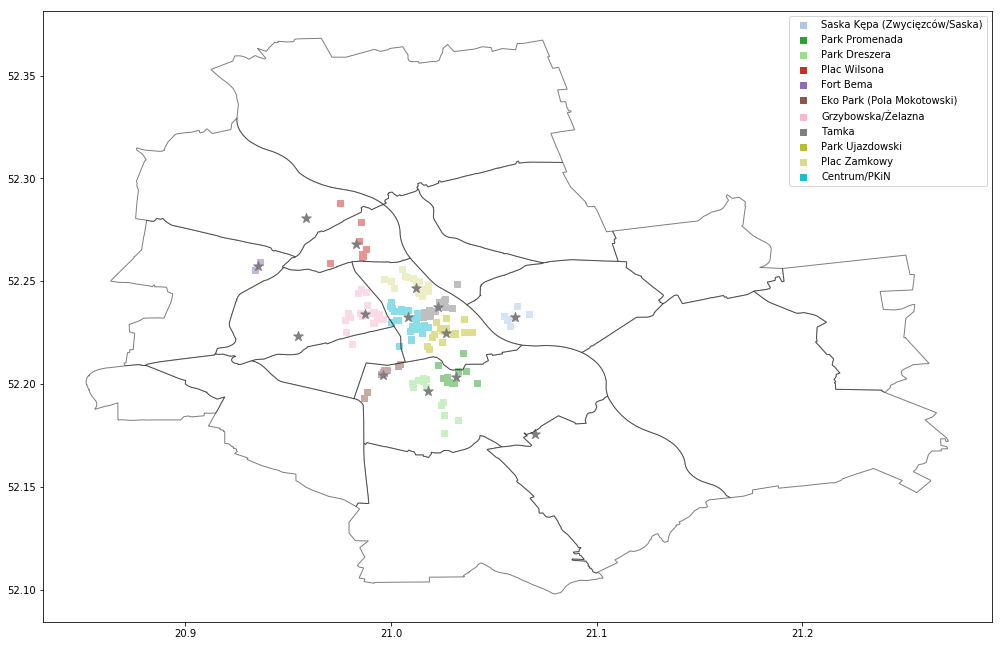

In [133]:
temp = pd.DataFrame(X)
temp.columns = ['lat','long']
temp['Clust'] = clusters

temp = temp.groupby(['Clust']).mean()

centers =dict()
centers[1] = 'Saska Kępa (Zwycięzców/Saska)'
centers[3] = 'Park Promenada'
centers[4] = 'Park Dreszera'
centers[5] = 'Plac Wilsona'
centers[6] = 'Fort Bema'
centers[8] = 'Eko Park (Pola Mokotowski)'
centers[10] = 'Grzybowska/Żelazna'
centers[11] = 'Tamka'
centers[12] = 'Park Ujazdowski'
centers[13] = 'Plac Zamkowy'
centers[14] = 'Centrum/PKiN'


fig = plt.figure(figsize=(17,17))
ax = fig.add_subplot(111)

cm = plt.get_cmap('tab20')

for name, polygon in poly.iteritems():  
    ax.add_patch(PolygonPatch(polygon, fc='w', ec='k', alpha=0.5, zorder=2))
ax.axis('scaled')
    
for clust in range(1,clusters.max()+1):
    long = []
    lat = []
    for obs in range(0, len(Z)): 
        if clusters[obs] == float(clust):
            long.append(X[obs,0])
            lat.append(X[obs,1])
    if clust in centers:
        ax.scatter(long, lat, s=30,c=cm(float(clust) / (clusters.max()+1)),marker='s',label=centers[clust])
plt.legend()
ax.scatter(temp['lat'], temp['long'], s=100,marker='*',c='black',label='Centers')

plt.show()

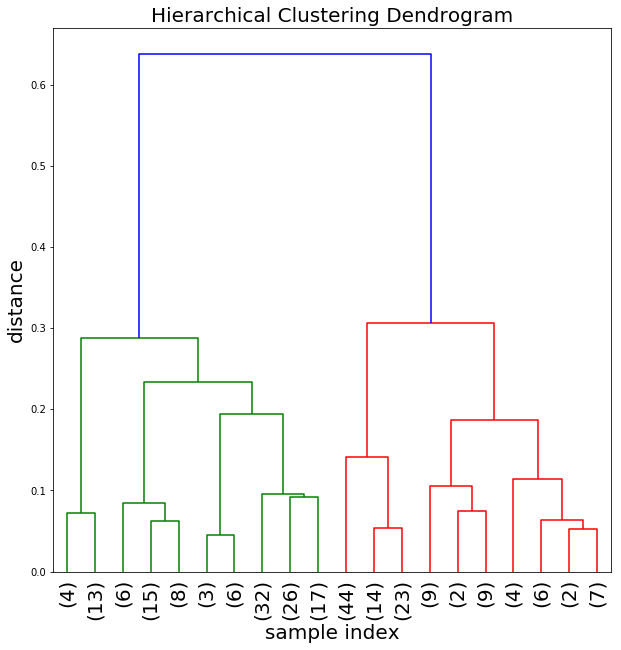

In [77]:
plt.figure(figsize=(10,10))
plt.title('Hierarchical Clustering Dendrogram',fontsize=20)
plt.xlabel('sample index',fontsize=20)
plt.ylabel('distance',fontsize=20)
dendrogram(Z, leaf_rotation=0, truncate_mode='lastp',  p=20, leaf_font_size=20.)
plt.xticks(rotation=90)
plt.show()

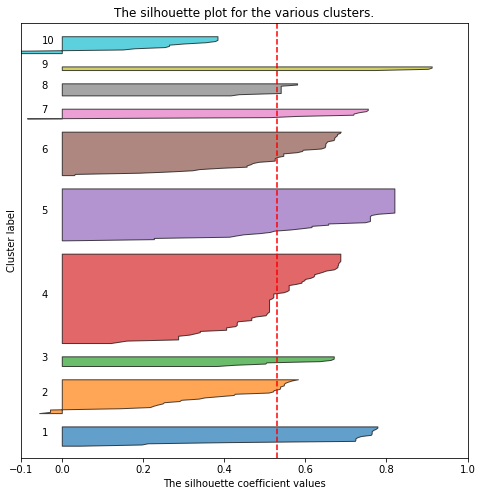

In [78]:
n_clusters = clusters.max()
fig ,ax1 = plt.subplots(figsize=(8,8))
ax1.set_xlim([-0.1, 1])
ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
silhouette_avg = silhouette_score(X, clusters)
# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X, clusters)
cmap = plt.get_cmap('tab10')
y_lower = 10
for i in range(1,n_clusters+1):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
        sample_silhouette_values[clusters == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = 'red'#cm.spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=cmap(float(i)/(n_clusters+1)), edgecolor='black', alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
plt.show()